In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('heart_num_0228.csv')
data.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'AgeCategory', 'HeightInMeters',
       'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting',
       'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos',
       'RaceEthnicityCategory_Black only, Non-Hispanic',
       'RaceEthnicityCategory_Hispanic',
       'RaceEthnicityCategory_Multiracial, Non-Hispanic',
       'RaceEthnicityCategory_Other race only, Non-Hispanic',
       'RaceEthnicityCategory_White only, N

In [3]:
Q1 = data[['SleepHours', 'BMI']].quantile(q = 0.25)
Q3 = data[['SleepHours', 'BMI']].quantile(q = 0.75)
IQR = Q3-Q1
data_iqr = data[(data['SleepHours'] <= Q3['SleepHours']+IQR['SleepHours']*1.5)&(data['SleepHours'] >= Q1['SleepHours']-IQR['SleepHours']*1.5)]
data_iqr = data_iqr[(data_iqr['BMI'] <= Q3['BMI']+IQR['BMI']*1.5)&(data_iqr['BMI'] >= Q1['BMI']-IQR['BMI']*1.5)]
print('Original data:', len(data))
print('Remove Outlier data:', len(data_iqr))

Original data: 274034
Remove Outlier data: 261812


In [4]:
X = data_iqr.drop(['HadHeartAttack'], axis = 1)
y = data_iqr['HadHeartAttack']

In [5]:
from imblearn.over_sampling import SMOTE

In [6]:
smo = SMOTE(random_state = 1234)
X_re, y_re = smo.fit_resample(X, y)
print('Original Data:', len(X))
print('Resampled Data:', len(X_re))

Original Data: 261812
Resampled Data: 494774


In [7]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state = 1234)

In [8]:
from sklearn.preprocessing import RobustScaler

In [12]:
rbs = RobustScaler()
X_trn = rbs.fit_transform(X_train)
X_tst = rbs.transform(X_test)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
print(X_trn.shape)

(395819, 46)


In [15]:
es = EarlyStopping(monitor = 'accuracy')

model = Sequential()
model.add(Dense(50, input_dim = 46, activation = 'relu'))
model.add(Dense(28, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', f1_m, precision_m, recall_m])
history = model.fit(X_trn, y_train, epochs = 100, batch_size = 10, callbacks = [es])



Epoch 1/100


39582/39582 [==============================] - 151s 4ms/step - loss: 0.1850 - accuracy: 0.9231 - f1_m: 0.9109 - precision_m: 0.9410 - recall_m: 0.9002
Epoch 2/100
39582/39582 [==============================] - 133s 3ms/step - loss: 0.1620 - accuracy: 0.9335 - f1_m: 0.9229 - precision_m: 0.9511 - recall_m: 0.9115
Epoch 3/100
39582/39582 [==============================] - 158s 4ms/step - loss: 0.1554 - accuracy: 0.9363 - f1_m: 0.9263 - precision_m: 0.9538 - recall_m: 0.9149
Epoch 4/100
39582/39582 [==============================] - 148s 4ms/step - loss: 0.1483 - accuracy: 0.9395 - f1_m: 0.9302 - precision_m: 0.9575 - recall_m: 0.9185
Epoch 5/100
39582/39582 [==============================] - 103s 3ms/step - loss: 0.1444 - accuracy: 0.9411 - f1_m: 0.9313 - precision_m: 0.9594 - recall_m: 0.9184
Epoch 6/100
39582/39582 [==============================] - 121s 3ms/step - loss: 0.1423 - accuracy: 0.9423 - f1_m: 0.9329 - precision_m: 0.9600 - recall_m: 0.9206
Epoch 7/100
39582/

In [16]:
loss, acc, f1, precision, recall = model.evaluate(X_trn, y_train)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc*100:.2f}%')
print(f'F1 Score: {f1:.4f}')

12370/12370 [==============================] - 28s 2ms/step - loss: 0.1306 - accuracy: 0.9492 - f1_m: 0.9465 - precision_m: 0.9667 - recall_m: 0.9303
Loss: 0.1306
Accuracy: 94.92%
F1 Score: 0.9465


In [17]:
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_f1 = history.history['f1_m']

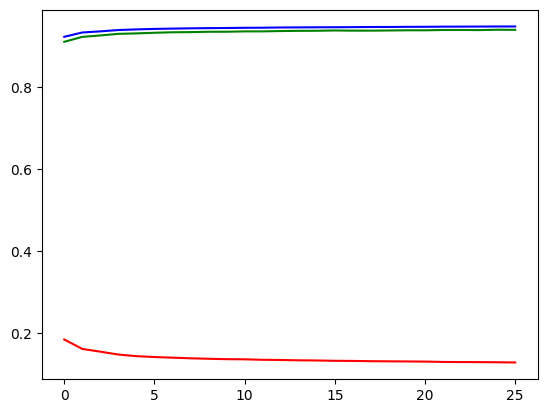

In [18]:
x_len = np.arange(len(y_acc))

plt.plot(x_len, y_loss,  c = 'red', markersize = 3)
plt.plot(x_len, y_acc, c = 'blue', markersize = 3)
plt.plot(x_len, y_f1, c = 'green', markersize = 3)
plt.show()